## Part I

### Hertz company

**The Hertz Corporation**, a subsidiary of Hertz Global Holdings, Inc., is an American car rental company based in Estero, Florida, that operates approximately **12,000** corporate and franchisee locations, both domestically and internationally. As one of the largest worldwide vehicle rental companies by sales, locations, and fleet size, Hertz operates in **160** countries in North America, Europe, Latin America, Africa, Asia, Australia, the Caribbean, the Middle East and New Zealand. The Hertz Corporation also owns Firefly Car Rental. 

### Goals of data transformation

Hertz recently undertook a massive digital transformation to evolve its technology landscape. 

**The goals Hertz was trying to achieve:**

* provide better view of customers (retail and corporate)
* improve customer journey from car reservation and all the way through 
* build global solution which allows better asset management
* reduce time to market
* allow business have insights about new opportunities from data analyzing 

**Problems Hertz observed before data transformation:**

* decentralized data storage with many legacy systems (no single source of data source was available for analytic, data science, etc. )
* data "was not working" (no analytic or insights from data) and as a result poor management decisions
* not able to do quick data look ups and as a result, poor client and asset management

The center of all of it is `data` which needs to be centralized, scaled quickly, analyzed, stored with less cost and be secured.


## Solution

### Solution at glance

As a platform for big data management Hertz choose **AWS services**. Simplified architecture of big data pipeline diagram is provided below. 

Data from many systems are entered cloud solution via several data input services/data consumers. Depending on the type of the data it could be Kinesis services, Glue services, Custom APIs (Application Programming Interfaces from external systems), Custom SFTPs (Secure File Transfer Proticol from external systems). 

Data consumers write data to Data Lake. Data lake is set of S3 buckets with different levels:

- Raw level S3 contains untouched data. Data consumers write data to S3 Raw level
- Curated level S3 contains processed data
- Conformed level S3 contains processed data. Data in that level is ready to be used by Data warehouse

Once data in Conformed level, it copies by lambda(computing serverless AWS service) to Data warehouse Redshift and to DynamoDB (AWS-owned high performance non relational database). From warehouse and DynamoDB data is ready to be consumed by downstream systems, reporting tools, data science tools.

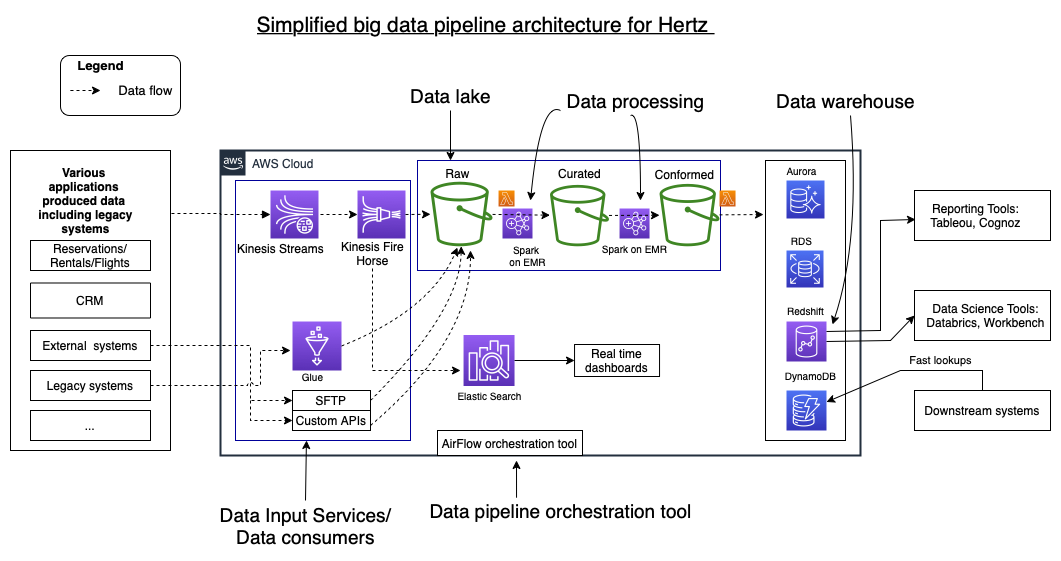


### Solution in details 
 
 
 Company has a lot of various systems which produces data. Hertz also consumes data from external systems like manufactures etc. Some of the company services are legacy and can produce only batched data. For the streamed data **AWS Kinesis Stream** and **AWS Kinesis FireHorse** are used as data consumers and write data to data lake in **S3** Raw level. 

 **Spark on EMR** with auto-scaling used as processing tool. Processed data is sent to Curated level **S3** bucket. Another **EMR cluster with Spark** processes the data and writes it to the next **S3** with Conformed level. Conformed level **S3** bucket serves as source for **Amazon Redshift with Spectrum**, **RDS**, **DynamoDB** and **AuroraDB**. AuroraDB is used for different types of log storing which are used for debug purposed. High performance DynamoDB is used for fast look ups for the processes when decision is time sensitive. 

Batched data from legacy systems, which are not able to stream data, consumed by **AWS Glue** which sends data to **S3** Raw level.

**Elastic search** uses for data discoveries and reads data from data lake S3 Raw level. Hertz utilizes raw data for more insights.

**Amazon Redshift with Spectrum** is used as data warehouse. 

**AWS Lambda** is used to copy date over from S3 conformed level to Redshift. Redshift is source for upstream systems which are reporting and data science tools.

As an workflow orchestration tool, Hertz uses **Apache Airflow**. 

All data manipulations, transformations, flows, as well as results of any actions against data are tracked with AWS monitoring services, such as **AWS Cloud Watch** and **AWS Cloud Trail**. Hertz also used Cloud Watch alerts in order to bring immediate attention to some critical metrics or to actions which require immediate attention.

In order to protect data, all data in transit and in rest is encrypted.

Redshift is a source of data for external reporting services and external data sciences tools. For reporting services Hertz uses Tableu and Cognoz and as external data science tools company uses Databricks and Workbench.

### Big data pipeline highlights:

* S3 used as datalake
* Data input through Kenesis Data Stream which is connected to Kinesis Data FireHorse.  Kinesis Data FireHorse writes data to S3.
* S3 has different layers: Raw level (data comes untouched from sources), Curated, Confirmed
* Row data is accessible in Elastic Search which allows to do discoveries
* All orchestration is done via AirFlow which triggers lambdas and move data from one bucket layer to another, etc
* Spark on EMR with auto-scaling used as data processed tool
* Redshift is used for dashboards and reads data from S3 Confirmed layer
* AuroraDB used for logs storing
* DynamoDB used to enable fast look ups (for example, to track flight changes and quickly find new options)
* All data is tracked (cloud watch logs, cloud trail logs are enabled)
* Event based lambda is used to trigger jobs for data processing as well as trigger alert notifications
* AWS Glue is used for batched data from legacy systems which are not able to stream data
* SFTP systems used for communication with external systems
* Reporting is done through the Tableou and Cognos which connected to Redshift/Spectrum
* Data is encrypted at rest and in transit
* All data and services in one availability zone

### Detailed big data pipeline architecure

Detailed Hertz data platform architecture is provide below (image is taken from  [AWS Re-Invent conference slides](https://d1.awsstatic.com/events/reinvent/2019/Accelerated_analytics_Building_the_next-gen_data_platform_for_Hertz_ARC414-S.pdf)). In this report we will touch only services directly involved in big data management. Most of AWS services which involved in big data pipeline are serverless (not need to manage infrastructure for these services, infrastructure will be provided by AWS under the hood). Hertz uses Infrastructure as Code(IaC) approach for provisioning infrastructure (Infrastructure as Code or IaC is the process of provisioning and managing infrastructure defined through code, instead of doing so with a manual process).

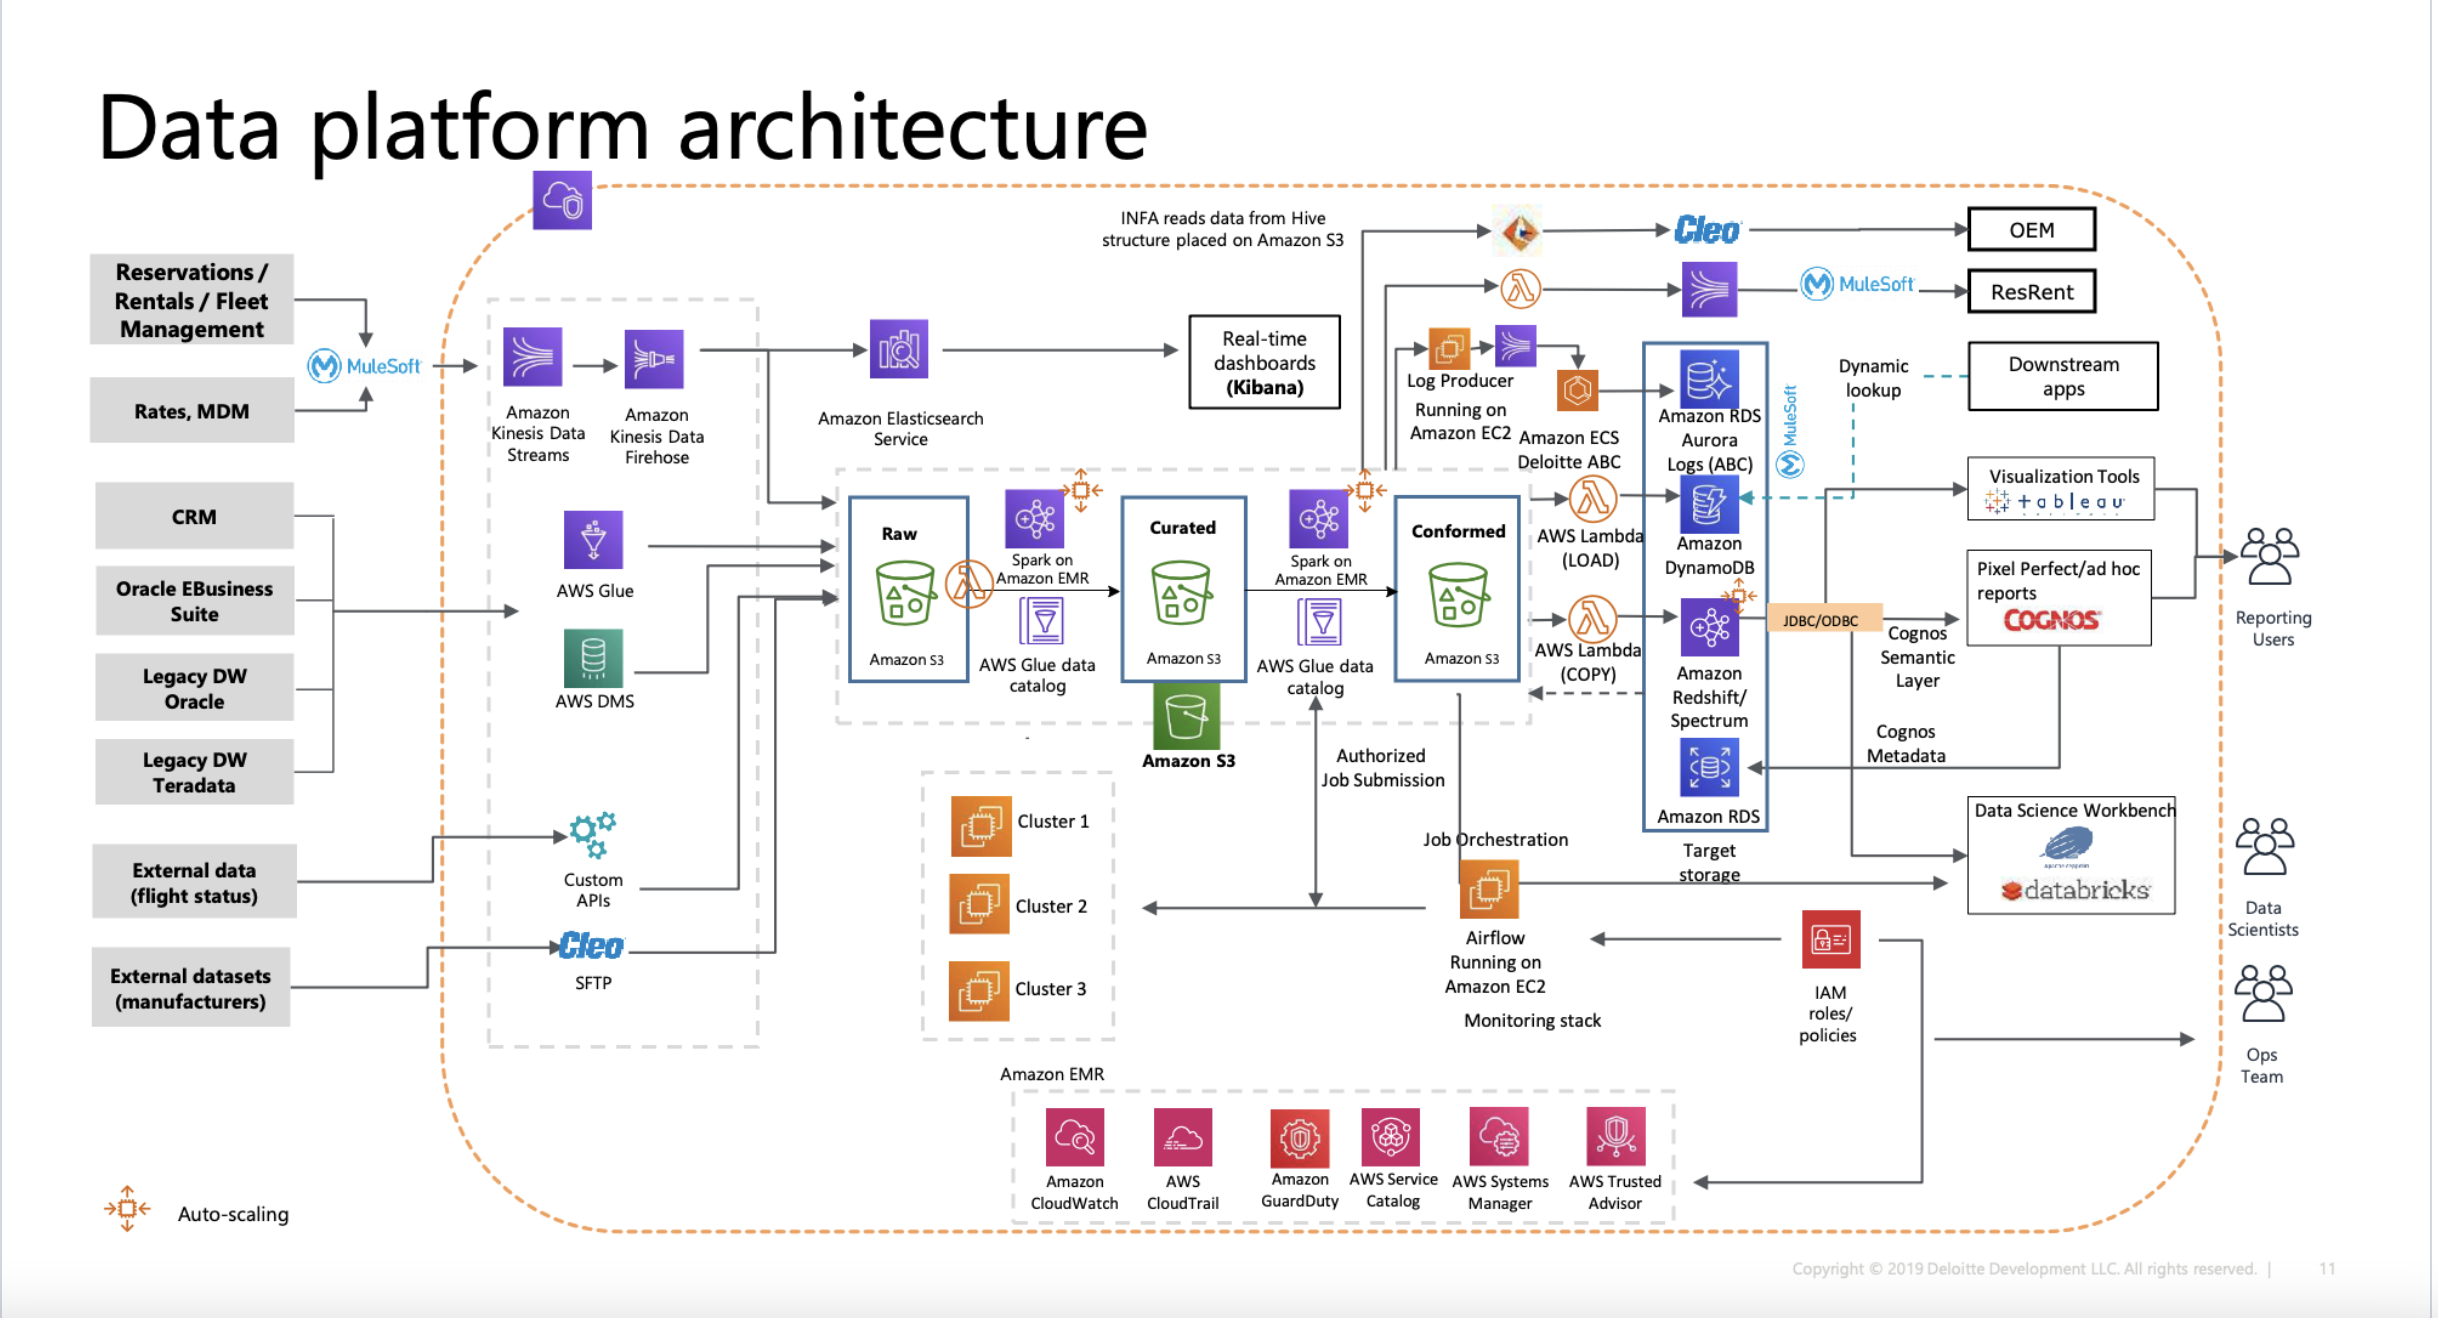

### Data input services

Data input is done through:

* **Amazon Kinesis Data Stream**  is a massively scalable, fully managed, serverless, highly durable data ingestion and processing service optimized for streaming data. It allows to configure hundreds of thousands of data producers to continuously put data into a Kinesis data stream. Data will be available within milliseconds to Amazon Kinesis applications, and those applications will receive data records in the order they were generated.

* **Amazon Kinesis Data Firehorse** is a fully managed service for delivering real-time streaming data to destinations such as Amazon Simple Storage Service (Amazon S3), Amazon Redshift, Amazon OpenSearch Service, Splunk, and any custom HTTP endpoint or HTTP endpoints.

* **AWS Glue** is a serverless data integration service that makes it easy to discover, prepare, and combine data for analytics, machine learning, and application development.

In Hertz case, Kinesis Data Streams used to read massive data which is mostly event based and IoT and Kinesis Data FireHorse consumes data from Kinesis Data Streams and stores all raw data in S3 Row level. AWS Glue consumes data from legacy systems and writes data to S3 Row level.

For communication with external systems SFTP (Secure Transfer File Protocol) or custom APIs used. 

### Data storage 

For data lake and for storage of processed data S3(Simple Storage Service) is used.

* **S3** is an object storage service that offers industry-leading scalability, data availability, security, and performance. This means customers of all sizes and industries can use it to store and protect any amount of data for a range of use cases, such as data lakes, websites, cloud-native applications, backups, archive, machine learning, and analytic. Amazon S3 is designed for 99.999999999% (11 9's) of durability, and stores data for millions of customers all around the world.

Hertz has three different layers of S3: Raw, Curated and Conformed. Untouched data from sources comes to S3 Raw layer. Firehorse or Glue writes to S3 Raw layer. Processed data moves from S3 Raw layer to S3 Curated and S3 Conformed. Spark on EMR used as processing tool.  S3 Conformed level is final destination the data. Redshift/Spectrum, Aurora and Dynamo DB read data from S3 Conformed.

### Data processing

As data processing tool, Spark on Amazon EMR used.

* **Apache Spark** is a multi-language engine for executing data engineering, data science, and machine learning on single-node machines or clusters.

* **Amazon EMR (Amazon Elastic MapReduce)** is a managed cluster platform that simplifies running big data frameworks, such as Apache Hadoop and Apache Spark, on Amazon to process and analyze vast amounts of data. Using these frameworks and related open-source projects, you can process data for analytics purposes and business intelligence workloads. Amazon EMR also lets you transform and move large amounts of data into and out of other Amazon data stores and databases, such as Amazon Simple Storage Service (Amazon S3) and Amazon DynamoDB.

Lambdas used to trigger Spark jobs on EMR. Lambda is also used to copy data from S3 Conformed layer to Redshift data warehouse.

* **AWS Lambda** is a serverless, event-driven compute service that lets you run code for virtually any type of application or backend service without provisioning or managing servers.

### Databases

Hertz uses **Amazon Aurora**, **DynamoDB** and **Amazon RDS**.

* **Amazon Relational Database Service (Amazon RDS)** is a collection of managed services that makes it simple to set up, operate, and scale databases in the cloud. 

* **Amazon Aurora** is a fully managed relational database engine that's compatible with MySQL and PostgreSQL.

* **Amazon DynamoDB** is a proprietary, fully managed, serverless, key-value NoSQL database designed to run high-performance applications at any scale. DynamoDB offers built-in security, continuous backups, automated multi-Region replication, in-memory caching, and data export tools.

Company uses Aurora for log storage. DynamoDB is used for fast look ups and Amazon RDS is used for meta-data storing for reporting systems.


### Data warehouse

Hertz uses **Amazon Redshift with Spectrum** as data warehouse. 

A data warehouse is a type of data management system that is designed to enable and support analytics. Data warehouses are solely intended to perform queries and analysis and often contain large amounts of historical data. The data within a data warehouse is derived from a wide range of sources.

* **Amazon Redshift** a fully managed, petabyte-scale data warehouse service in the cloud. **Spectrum** is a tool within Amazon Redshift which allows to conduct fast, complex analysis on objects stored on the AWS cloud. With Redshift Spectrum, an analyst can perform SQL queries on data stored in Amazon S3 buckets.

Data from `conformed S3 bucket` is copied to Redshift. The copy process is done by Lambda service.


### Monitoring services

All data is tracked. Hertz uses **Amazon Cloud Watch** and **Amazon Cloud Trail** to track all data activities and as, well as throw alerts.

* **Amazon Cloud Watch** is a monitoring and observability service. CloudWatch provides data and actionable insights to monitor applications, respond to system-wide performance changes, and optimize resource utilization. CloudWatch collects monitoring and operational data in the form of logs, metrics, and events.

* **Amzon Cloud Trail** is service that helps enable governance, compliance, and operational and risk auditing of AWS account. Actions taken by a user, role, or an AWS service are recorded as events in CloudTrail. Events include actions taken in the AWS Management Console, AWS Command Line Interface, and AWS SDKs and APIs.


### Orchestration Tool

Hertz uses Apache Airflow to orchestrate data workflow processes. Airflow used to trigger lambdas, move data between S3 bucket levels.

Apache Airflow is a top-rated workflow management platform, and its open-source and free nature has attracted a large number of users to it. Today, the Apache Airflow ecosystem is maintained by hundreds of members. Apache Airflow is commonly used to run ETL jobs, manage machine learning pipelines, and automate development tasks.

Today, using Amazon-managed Apache Airflow workflows, the user can write, schedule, and monitor workflows using airflow from within AWS without facing the everyday challenges of running the airflow environment. Managed workflows take care of the airflow environment setup, scaling, security, and handling upgrades and monitoring. This means the user can spend less time managing your airflow environments and more time using them to perform your data processing workflows in the cloud.

Airflow workflows are typically represented as a collection of all the tasks you want to run, organized in a way that reflects their relationships and dependencies. In technical terms, this collection of tasks is called a directed acyclic graph, or DAG. To define workflows in airflow, users typically write DAGs in Python.

## Summary

Hertz was able to successfully evolve its technology landscape. The implemented big data pipeline allows to centralize data in one place, including data from legacy systems and external systems. By implementing cloud solution described in that report, Hertz was able significantly improve company's data analytic and reporting processes, constantly gets insights from data and as a result of all these changes improved customers experience and asset management.

## Part II

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
con = sqlite3.connect('northwind.sqlite')
q = '''
    SELECT name
    FROM sqlite_schema
    WHERE type = "table";
    '''

df = pd.read_sql_query(q, con)
df

,name
0,Categories
1,sqlite_sequence
2,CustomerCustomerDemo
3,CustomerDemographics
4,Customers
5,Employees
6,EmployeeTerritories
7,Order Details
8,Orders
9,Products


In [3]:
orders_per_empl = pd.merge(
  left = pd.read_sql("Select OrderID, EmployeeID from Orders", con),
  right = pd.read_sql("Select DISTINCT EmployeeID, LastName from Employees", con),
  how = "left",
  on = "EmployeeID")

#### Overall number of orders per employee

Find overall number of orders per each employee for the whole period and sort them in descending order.

In [4]:
orders_per_empl = orders_per_empl.groupby(['EmployeeID', 'LastName']).count()
orders_per_empl = orders_per_empl.reset_index()
orders_per_empl.columns = ['EmployeeID', 'LastName', 'orders_count']
orders_per_empl.sort_values('orders_count', axis=0, ascending=False, inplace=True)
orders_per_empl

,EmployeeID,LastName,orders_count
3,4,Peacock,156
2,3,Leverling,127
0,1,Davolio,123
7,8,Callahan,104
1,2,Fuller,96
6,7,King,72
5,6,Suyama,67
8,9,Dodsworth,43
4,5,Buchanan,42


#### Order numbers per employee across months

Find order counts for each employee in six months period.

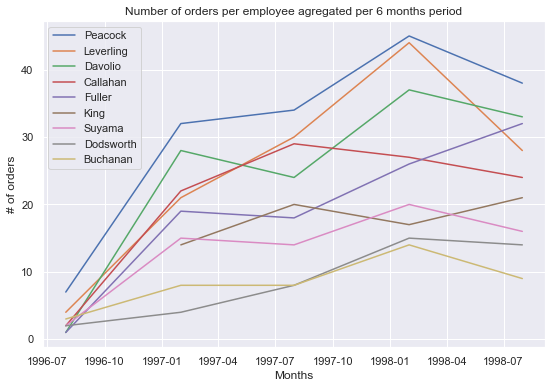

In [112]:
orders_by_date = pd.merge(
  left = pd.read_sql("Select EmployeeID, OrderDate from Orders", con),
  right = pd.read_sql("Select EmployeeID, LastName from Employees", con),
  how = "left",
  on = "EmployeeID")


orders_by_date['OrderDate'] = pd.to_datetime(orders_by_date['OrderDate'])
orders_by_date = orders_by_date.groupby(['LastName', pd.Grouper(key='OrderDate', freq='6M')]).count()

orders_by_date = orders_by_date.reset_index()
orders_by_date.columns = ['LastName', 'OrderDate', 'orders_count']
orders_by_date


#df.groupby(pd.Grouper(key='Date', freq='2Y')).sum()
empl_names = orders_per_empl['LastName'].to_list()

plt.rcParams["figure.figsize"]= (9,6)
for i in range(len(empl_names)):
    tmp = orders_by_date.loc[ (orders_by_date["LastName"] == empl_names[i])]
    plt.plot(tmp.OrderDate, tmp.orders_count, label = empl_names[i])
plt.title("Number of orders per employee agregated per 6 months period")
plt.xlabel("Months")
plt.ylabel("# of orders")
plt.legend()
plt.show()
plt.close()    

#### Orders per category

For each employee find how orders for the whole period employee has in each product category.

In [6]:
q = '''
    select Orders.EmployeeID, Employees.LastName, Orders.OrderID, [Order Details].ProductID, Products.CategoryID, Categories.CategoryName
    from Orders
    left join Employees on Employees.EmployeeID = Orders.EmployeeID
    left join [Order Details] on Orders.OrderID = [Order Details].OrderID
    left join Products on [Order Details].ProductID = Products.ProductID
    left join Categories on Products.CategoryID = Categories.CategoryID
    '''
df = pd.read_sql_query(q, con)
data = df.loc[:, ('LastName','CategoryName', 'OrderID')].groupby(['LastName', 'CategoryName']).count()
data = data.reset_index()
data.columns = ['LastName', 'CategoryName', 'OrderNumWithCategory']

Text(10.059355709876549, 0.5, 'Number of orders per category')

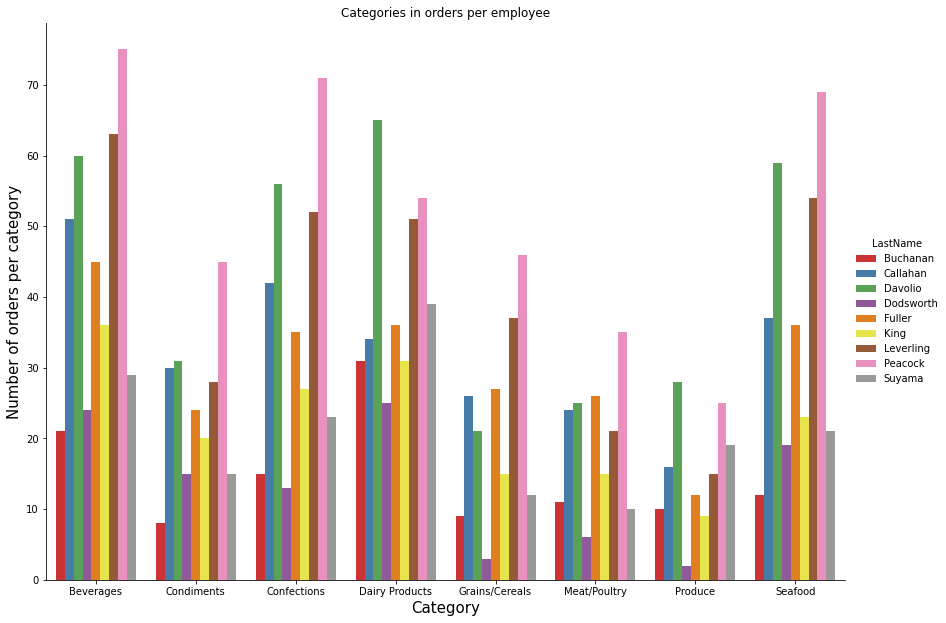

In [7]:
import seaborn as sns

g = sns.catplot(x='CategoryName', y='OrderNumWithCategory', data=data, kind='bar', 
                hue='LastName', 
                legend=True,
                palette='Set1',
                height=8.27, aspect=11.7/8.27).set(title='Categories in orders per employee')
plt.xlabel("Category", size=15)
plt.ylabel("Number of orders per category", size=15)

Different view on the same data.

Text(10.757465277777783, 0.5, 'Number of orders per category')

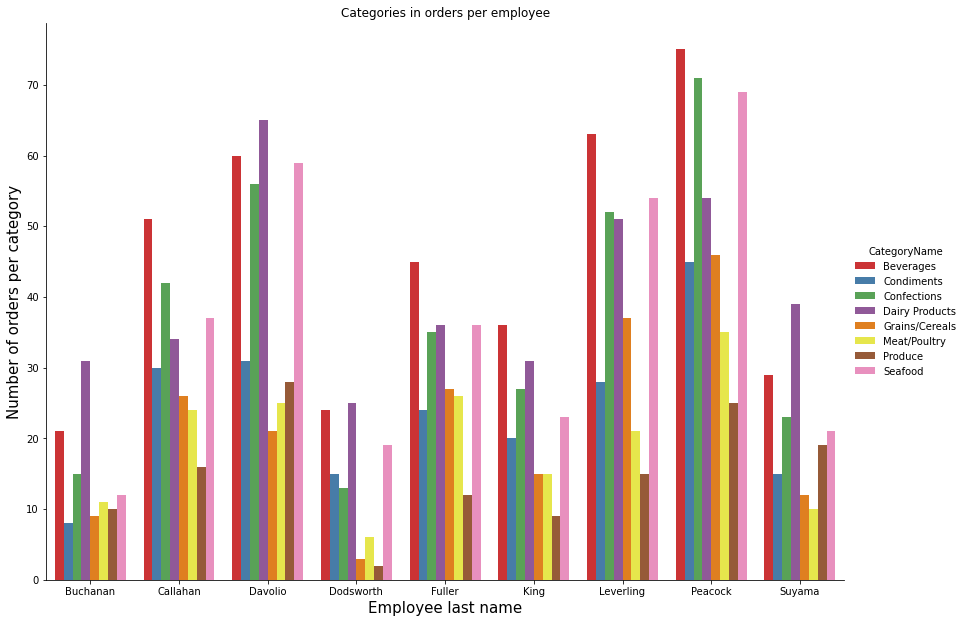

In [8]:
g = sns.catplot(x='LastName', y='OrderNumWithCategory', data=data, kind='bar', 
                hue='CategoryName', 
                legend=True,
                palette='Set1',
                height=8.27, aspect=11.7/8.27).set(title='Categories in orders per employee')
plt.xlabel("Employee last name", size=15)
plt.ylabel("Number of orders per category", size=15)

#### Employees vs Customers Countries

For each employee find top 7 countries for their customers countries.

In [9]:
q = '''
    select Orders.EmployeeID, Employees.LastName, Customers.CompanyName, Customers.Country
    from Orders
    left join Customers on Orders.CustomerID = Customers.CustomerID
    left join Employees on Employees.EmployeeID = Orders.EmployeeID
    '''

df = pd.read_sql_query(q, con)
orders_per_country_all = 
orders_per_country_allpd.crosstab (df.Country, df.LastName)

LastName,Buchanan,Callahan,Davolio,Dodsworth,Fuller,King,Leverling,Peacock,Suyama
Country,,,,,,,,,
Argentina,0,3,1,2,1,3,1,4,1
Austria,0,5,5,3,6,6,5,6,4
Belgium,4,0,1,2,2,2,1,6,1
Brazil,5,9,11,3,9,8,10,20,8
Canada,0,2,5,1,5,2,9,3,3
Denmark,0,2,4,0,3,4,1,3,1
Finland,2,4,2,1,6,1,2,3,1
France,5,8,9,3,11,5,13,14,9
Germany,4,17,19,9,14,6,19,25,9


Text(0.5, 0.98, "Top 7(based on number of orders) customer's countries per each employee")

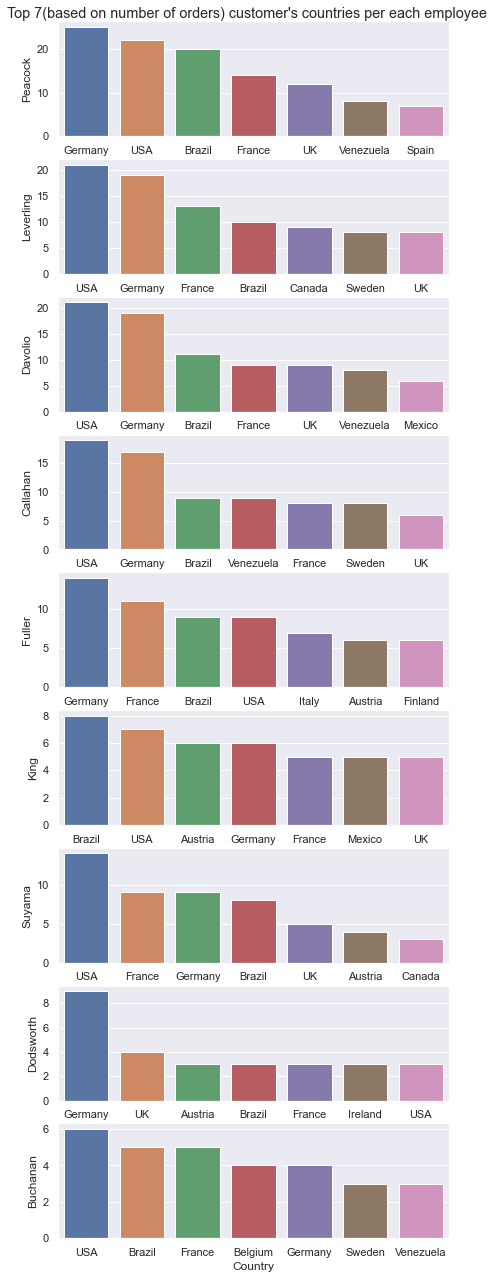

In [56]:
sns.set()
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(7,20))
for x in range(len(empl_names)):
    df = orders_per_country_all.nlargest (7, empl_names[x]).loc[:, empl_names[x]]
    df = df.to_frame() 
    sns.barplot(x=df.index, y=empl_names[x], data=df, ax=ax[x])
fig.subplots_adjust(top=0.97)    
fig.suptitle("Top 7(based on number of orders) customer's countries per each employee")    

#### Seven counties with smallest number of orders per employee

In [119]:
for x in range(len(empl_names)):
    df = orders_per_country_all.nsmallest (7, empl_names[x]).loc[:, empl_names[x]]
    df = df = df.to_frame()
    #df.reset_index()
    print ("7 countries with least overall # of orders and overall # of orders in this country for employee " + empl_names[x])
    print ("-------------------------------------------------------------------")
    print (df)

7 countries with least overall # of orders and overall # of orders in this country for employee Peacock
-------------------------------------------------------------------
          Peacock
Country          
Norway          0
Ireland         1
Poland          2
Canada          3
Denmark         3
Finland         3
Portugal        3
7 countries with least overall # of orders and overall # of orders in this country for employee Leverling
-------------------------------------------------------------------
           Leverling
Country             
Poland             0
Argentina          1
Belgium            1
Denmark            1
Italy              1
Norway             1
Finland            2
7 countries with least overall # of orders and overall # of orders in this country for employee Davolio
-------------------------------------------------------------------
           Davolio
Country           
Argentina        1
Belgium          1
Ireland          1
Finland          2
Norway           

### Orders ship country

For each employee find top 7 countries where their orders were shipped.

In [64]:
q = '''
    select Employees.LastName, Orders.ShipCountry, Orders.OrderID
    from Employees
    left join Orders on Orders.EmployeeID = Employees.EmployeeID
    '''
ord_ship_country = pd.read_sql_query(q, con)
ord_ship_country

ord_ship_country = pd.crosstab (ord_ship_country.ShipCountry, ord_ship_country.LastName)
ord_ship_country

LastName,Buchanan,Callahan,Davolio,Dodsworth,Fuller,King,Leverling,Peacock,Suyama
ShipCountry,,,,,,,,,
Argentina,0,3,1,2,1,3,1,4,1
Austria,0,5,5,3,6,6,5,6,4
Belgium,4,0,1,2,2,2,1,6,1
Brazil,5,9,11,3,9,8,10,20,8
Canada,0,2,5,1,5,2,9,3,3
Denmark,0,2,4,0,3,4,1,3,1
Finland,2,4,2,1,6,1,2,3,1
France,5,8,9,3,11,5,13,14,9
Germany,4,17,19,9,14,6,19,25,9


### Order prices

For each employee find order prices distribution. 

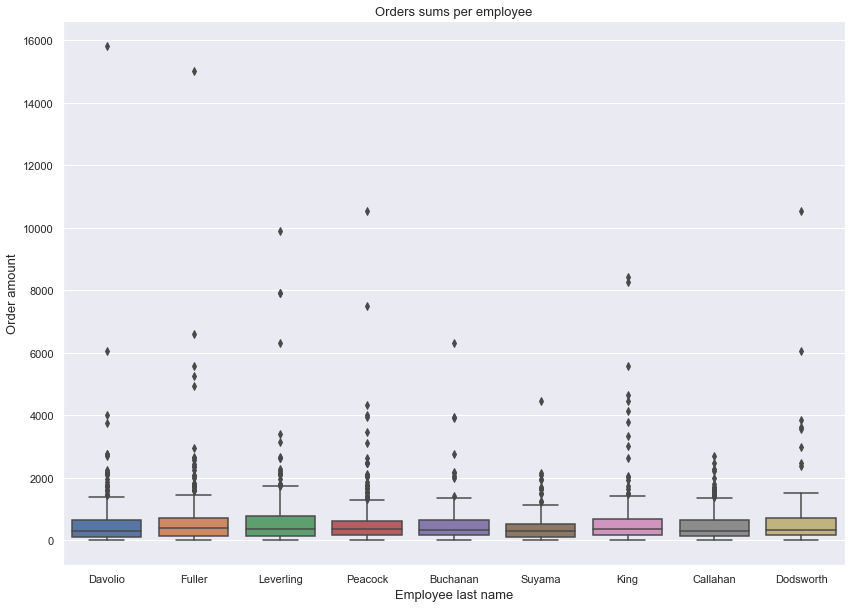

In [57]:
q = '''
    select Employees.EmployeeID, Employees.LastName, 
    [Order Details].OrderID, 
    [Order Details].UnitPrice, 
    [Order Details].Quantity,
    [Order Details].Discount,
    Orders.OrderDate
    from Employees
    left join Orders on Orders.EmployeeID = Employees.EmployeeID
    left join [Order Details] on [Order Details].OrderID = Orders.OrderID
    '''

ord_amount_per_empl = pd.read_sql_query(q, con)
ord_amount_per_empl['OrderTotal']=ord_amount_per_empl['Quantity']*ord_amount_per_empl['UnitPrice']-ord_amount_per_empl['Quantity']*ord_amount_per_empl['UnitPrice']*ord_amount_per_empl['Discount']

sns.boxplot(y="OrderTotal", x =  "LastName", data=ord_amount_per_empl)
plt.ylabel("Order amount", size=13)
plt.xlabel("Employee last name", size=13)
plt.title("Orders sums per employee", size=13) 
plt.show()

In [28]:
#sns.scatterplot(data=ord_amount_per_empl, x="OrderDate", y="OrderTotal", hue="LastName")


#### Total orders sums for each employee

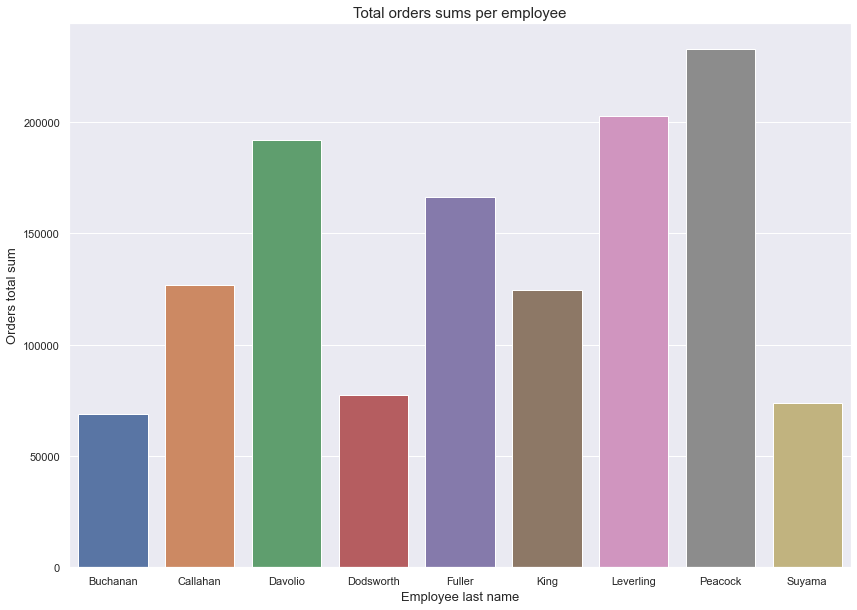

In [58]:
total_sums_per_empl = ord_amount_per_empl[['LastName', 'OrderTotal']].groupby('LastName').sum()
total_sums_per_empl
sns.barplot(x=total_sums_per_empl.index, y='OrderTotal', data=total_sums_per_empl)
plt.ylabel("Orders total sum", size=13)
plt.xlabel("Employee last name", size=13)
plt.title("Total orders sums per employee", size=15)
plt.show()

## Part III

In [35]:
import pandas as pd
import numpy as np
import pyspark.pandas as ps
from pyspark.sql import SparkSession
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [40]:
url = 'https://www4.stat.ncsu.edu/~online/datasets/scoresFull.csv'
from pyspark import SparkFiles
spark = SparkSession.builder.appName('app_name').getOrCreate()
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("scoresFull.csv"), header=True)
#df = df.to_pandas_on_spark()

In [41]:
averages = df.agg({'AQ1': 'avg', 'AQ2': 'avg', 'AQ3': 'avg', 'AQ4': 'avg', 
              'AFinal': 'avg', 'HQ1': 'avg', 'HQ2': 'avg', 'HQ3': 'avg', 'HQ4': 'avg', 'HFinal': 'avg'})
averages.show()

+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+
|      avg(AFinal)|        avg(AQ3)|         avg(HQ2)|      avg(HFinal)|         avg(AQ4)|         avg(HQ1)|          avg(AQ1)|         avg(HQ3)|         avg(HQ4)|         avg(AQ2)|
+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+
|20.55718813022184|4.38692019590896|7.105157015269374|23.17401325266494|5.890233362143475|4.828867761452031|3.9248055315471047|4.791126476519735|6.322961682512244|6.241428983002017|
+-----------------+----------------+-----------------+-----------------+-----------------+-----------------+------------------+-----------------+-----------------+-----------------+



In [42]:
stddevs = df.agg({'AQ1': 'stddev', 'AQ2': 'stddev', 'AQ3': 'stddev', 'AQ4': 'stddev', 
              'AFinal': 'stddev', 'HQ1': 'stddev', 'HQ2': 'stddev', 'HQ3': 'stddev', 'HQ4': 'stddev', 'HFinal': 'stddev'})
stddevs.show()

+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+
|    stddev(AFinal)|      stddev(AQ3)|       stddev(HQ2)|    stddev(HFinal)|      stddev(AQ4)|      stddev(HQ1)|      stddev(AQ1)|      stddev(HQ3)|      stddev(HQ4)|       stddev(AQ2)|
+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+
|10.195585841440776|4.632716825002489|5.7027880761372725|10.405951744024184|5.278775371882617|4.726903424009668|4.490700421089049|4.755144845943295|5.417310283450343|5.2215934529573085|
+------------------+-----------------+------------------+------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+



In [43]:
averages_grouped = df.groupby('season').agg({'AQ1': 'avg', 'AQ2': 'avg', 'AQ3': 'avg', 'AQ4': 'avg', 
              'AFinal': 'avg', 'HQ1': 'avg', 'HQ2': 'avg', 'HQ3': 'avg', 'HQ4': 'avg', 'HFinal': 'avg'})
averages_grouped.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|season|       avg(AFinal)|          avg(AQ3)|          avg(HQ2)|       avg(HFinal)|          avg(AQ4)|          avg(HQ1)|          avg(AQ1)|          avg(HQ3)|          avg(HQ4)|          avg(AQ2)|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  2012|21.655430711610485|  4.50936329588015|  7.00374531835206|24.119850187265918| 6.235955056179775| 4.928838951310861| 4.468164794007491| 5.217228464419476| 6.823970037453184| 6.273408239700374|
|  2014|21.295880149812735| 4.734082397003745| 7.164794007490637|23.973782771535582| 5.876404494382022| 4.913857677902621| 4.284644194756554| 5.397003745318352|6.3745318352059925| 6.322097378277154|
|  20

In [44]:
stddevs_grouped = df.groupby('season').agg({'AQ1': 'stddev', 'AQ2': 'stddev', 'AQ3': 'stddev', 'AQ4': 'stddev', 
              'AFinal': 'stddev', 'HQ1': 'stddev', 'HQ2': 'stddev', 'HQ3': 'stddev', 'HQ4': 'stddev', 'HFinal': 'stddev'})
stddevs_grouped.show()

+------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|season|    stddev(AFinal)|       stddev(AQ3)|       stddev(HQ2)|    stddev(HFinal)|       stddev(AQ4)|      stddev(HQ1)|       stddev(AQ1)|       stddev(HQ3)|      stddev(HQ4)|      stddev(AQ2)|
+------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+
|  2012| 10.36700586582552| 4.627771103085967| 5.379925180001318| 10.55991939940039| 5.338234491542525|4.504654209720631| 4.754293429927693|4.5427794268808634|5.675672459168211|5.452819233053018|
|  2014| 9.780605611153137|5.0598373811825486|  6.11381680118567|10.870878612249262| 5.243299106476734|4.821247898934106| 4.893745832711619|5.1845336805684195|5.329216822540802|  4.7692229255708|
|  2013| 9.680199379

In [45]:
averages_grouped = averages_grouped.toPandas()
averages_grouped.sort_values('season', axis=0, ascending=True, inplace=True)

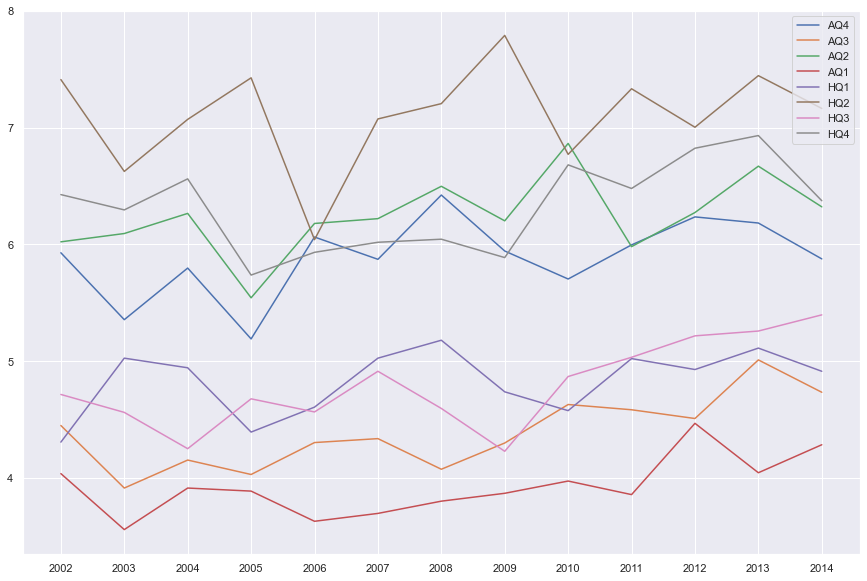

In [53]:
plt.plot (averages_grouped.season, averages_grouped['avg(AQ4)'], label = "AQ4")
plt.plot (averages_grouped.season, averages_grouped['avg(AQ3)'], label = "AQ3")
plt.plot (averages_grouped.season, averages_grouped['avg(AQ2)'], label = "AQ2")
plt.plot (averages_grouped.season, averages_grouped['avg(AQ1)'], label = "AQ1")
plt.plot (averages_grouped.season, averages_grouped['avg(HQ1)'], label = "HQ1")
plt.plot (averages_grouped.season, averages_grouped['avg(HQ2)'], label = "HQ2")
plt.plot (averages_grouped.season, averages_grouped['avg(HQ3)'], label = "HQ3")
plt.plot (averages_grouped.season, averages_grouped['avg(HQ4)'], label = "HQ4")
#plt.plot (averages_grouped.season, averages_grouped['avg(HFinal)'], label = "H Final", linestyle='dashed')
plt.legend()
plt.gcf().set_size_inches(15, 10)
plt.show()